In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from random import choice
import imageio.v2 as imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
L = 40
Nfish = 300
Nshark = 10
fishBreedTime = 3
sharkBreedTime = 20
maxEnergy = 3
evolutionSteps = 500
cmap = colors.ListedColormap(['aquamarine', 'forestgreen', 'k']) #0 is water, 1 is a fish, 2 is a shark

In [4]:
class Fish:
  def __init__(self, x, y, age, breed_time=fishBreedTime):
    self.x = x
    self.y = y
    self.age = age
    self.breed_time = breed_time

  def checkPossibilities(self, world):
    moves = []
    if world.lattice[(self.x - 1) % world.L][self.y] == 0:
      moves += [ ((self.x - 1) % world.L, self.y) ]

    if world.lattice[(self.x + 1) % world.L][self.y] == 0:
      moves += [ ((self.x + 1) % L, self.y) ]

    if world.lattice[self.x][(self.y - 1) % L] == 0:
      moves += [ (self.x, (self.y - 1) % L)]

    if world.lattice[self.x][(self.y + 1) % L] == 0:
      moves += [ (self.x, (self.y + 1) % L) ]

    return moves

  def moveFish(self, world):
    possibleMoves = self.checkPossibilities(world)
    if len(possibleMoves) != 0:
      if possibleMoves != []:
        choosenMove = choice(possibleMoves)
        x_new = choosenMove[0]
        y_new = choosenMove[1]

        x_old = self.x
        y_old = self.y
        index = world.fish_coordinates.index((x_old, y_old))

        self.x = x_new
        self.y = y_new
        world.fish_coordinates[index] = (x_new, y_new)

        world.lattice[x_new][y_new] = 1

        if self.age > self.breed_time:
          world.fishes += [ Fish(x_old, y_old, 0) ]
          world.fish_coordinates += [ (x_old, y_old) ]
          self.age = 0

        else:
          world.lattice[x_old][y_old] = 0

  def liveOneDay(self, world):
    self.age += 1
    self.moveFish(world)

In [5]:
class Shark:
  def __init__(self, x, y, age, energy, breed_time=sharkBreedTime, max_energy=maxEnergy):
    self.x = x
    self.y = y
    self.age = age
    self.energy = energy
    self.breed_time = breed_time
    self.max_energy = max_energy

  def checkPossibilities(self, world):
    moves = []

    if world.lattice[(self.x - 1) % world.L][self.y] == 1:
      moves += [ ((self.x - 1) % world.L, self.y) ]

    if world.lattice[(self.x + 1) % world.L][self.y] == 1:
      moves += [ ((self.x + 1) % world.L, self.y) ]

    if world.lattice[self.x][(self.y - 1) % L] == 1:
      moves += [ (self.x, (self.y - 1) % world.L)]

    if world.lattice[self.x][(self.y + 1) % L] == 1:
      moves += [ (self.x, (self.y + 1) % world.L) ]

    else:
      if world.lattice[(self.x - 1) % world.L][self.y] == 0:
        moves += [ ((self.x - 1) % world.L, self.y) ]

      if world.lattice[(self.x + 1) % world.L][self.y] == 0:
        moves += [ ((self.x + 1) % world.L, self.y) ]

      if world.lattice[self.x][(self.y - 1) % world.L] == 0:
        moves += [ (self.x, (self.y - 1) % world.L)]

      if world.lattice[self.x][(self.y + 1) % world.L] == 0:
        moves += [ (self.x, (self.y + 1) % world.L) ]

    return moves

  def moveShark(self, world):
    x_old = self.x
    y_old = self.y
    possibleMoves = self.checkPossibilities(world)
    if len(possibleMoves) != 0:
      if possibleMoves != []:

        choosenMove = choice(possibleMoves)
        x_new = choosenMove[0]
        y_new = choosenMove[1]

        index = world.shark_coordinates.index((x_old, y_old))

        self.x = x_new
        self.y = y_new
        world.shark_coordinates[index] = (x_new, y_new)

        world.lattice[x_new][y_new] = 2
        if self.age > self.breed_time:
          world.sharks += [ Shark(x_old, y_old, 0, self.max_energy) ]
          world.shark_coordinates += [ (x_old, y_old) ]
          self.age = 0

        else:
          world.lattice[x_old][y_old] = 0

        if choosenMove in world.fish_coordinates:
          index = world.fish_coordinates.index(choosenMove)
          if 0 <= index < len(world.fishes) and 0 <= index < len(world.fish_coordinates):
            removed_fish = world.fishes.pop(index)
            removed_coordinates = world.fish_coordinates.pop(index)
            self.energy = self.max_energy

  def liveOneDay(self, world):
    self.age += 1
    self.energy -= 1
    self.moveShark(world)

    if self.energy == 0:
      world.lattice[self.x][self.y] = 0
      world.sharks.remove(self)
      world.shark_coordinates.remove((self.x, self.y))

    if self.energy > self.max_energy:
      self.energy = self.max_energy

In [6]:
class World:
  def __init__(self, L):
    self.L = L
    self.lattice = np.zeros((L,L))
    self.fishes = []
    self.fish_coordinates = []
    self.sharks = []
    self.shark_coordinates = []

  def showLattice(self):
    cmap = colors.ListedColormap(['aquamarine', 'forestgreen', 'k'])
    plt.matshow(self.lattice, cmap=cmap, fignum=None, interpolation='nearest')

  def generateAnimals(self, Nfish, Nshark, maxEnergy):
    prey = 0
    predator = 0

    if Nfish + Nshark > L**2:
      return ValueError('Too many animals!')

    while prey < Nfish:
      x_rand = np.random.randint(0, L)
      y_rand = np.random.randint(0, L)

      if self.lattice[x_rand][y_rand] == 0:
        self.fishes += [ Fish(x_rand, y_rand, 0) ]
        self.fish_coordinates += [ (x_rand, y_rand) ]
        self.lattice[x_rand][y_rand] = 1
        prey += 1

    while predator < Nshark:
      x_rand = np.random.randint(0, L)
      y_rand = np.random.randint(0, L)

      if self.lattice[x_rand][y_rand] == 0:
        randomEnergy = np.random.randint(1, maxEnergy + 1)
        self.sharks += [ Shark(x_rand, y_rand, 0, randomEnergy) ]
        self.shark_coordinates += [ (x_rand, y_rand) ]
        self.lattice[x_rand][y_rand] = 2
        predator += 1


  def liveOneDay(self):
    tempFish = self.fishes
    for fish in tempFish:
      fish.liveOneDay(self)

    tempSharks = self.sharks
    for shark in tempSharks:
      shark.liveOneDay(self)

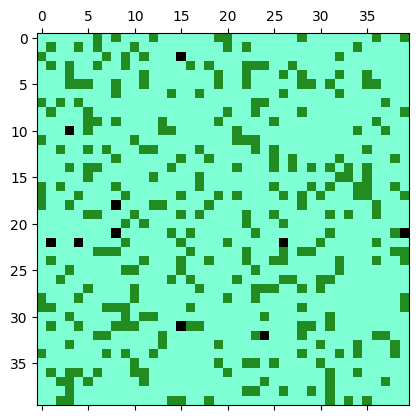

In [25]:
world = World(L)
world.generateAnimals(Nfish, Nshark, maxEnergy)
world.showLattice()

In [23]:
for i in range(evolutionSteps):
  world.liveOneDay()
  plt.matshow(world.lattice, cmap=cmap, fignum=None, interpolation='nearest')
  plt.savefig(f"/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/WATOR{i}.png", dpi=200)
  plt.close()

In [24]:
png_dir = '/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
        os.remove(file_path)

imageio.mimsave( '/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/movie.gif', images)

In [26]:
steps = []
preys = []
predators = []

for i in range(evolutionSteps):
  steps += [ i ]
  preys += [ len(world.fishes) ]
  predators += [ len(world.sharks) ]

  world.liveOneDay()

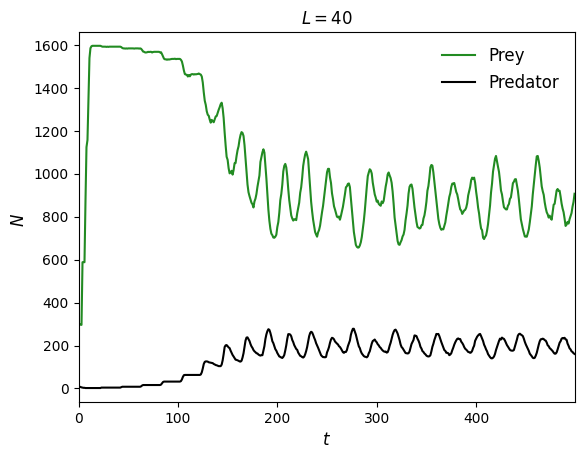

In [27]:
plt.plot(steps, preys,  color='forestgreen', linestyle='solid', label='Prey')
plt.plot(steps, predators,  color='k', linestyle='solid',  label='Predator')

plt.title(fr'$L = 40$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$N$  ', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/Steps40.png', dpi=1200)
plt.show()

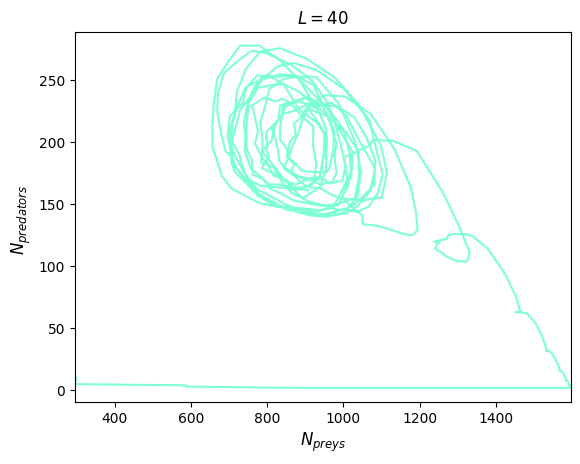

In [28]:
plt.plot(preys, predators,  color='aquamarine', linestyle='solid')

plt.title(fr'$L = 40$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$N_{preys}$', fontsize=12)
plt.ylabel(r'$N_{predators}$  ', fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/PreyPredator40.png', dpi=1200)
plt.show()

In [29]:
L = 200
Nfish = 300
Nshark = 10
fishBreedTime = 3
sharkBreedTime = 20
maxEnergy = 3
evolutionSteps = 500
cmap = colors.ListedColormap(['aquamarine', 'forestgreen', 'k']) #0 is water, 1 is a fish, 2 is a shark

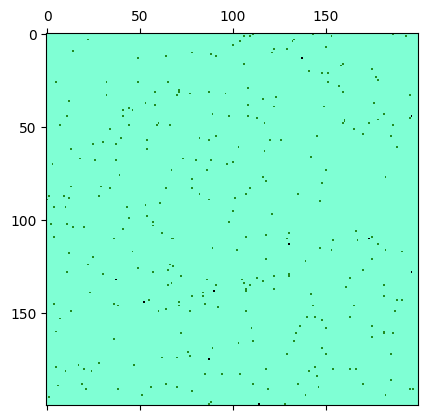

In [30]:
world = World(L)
world.generateAnimals(Nfish, Nshark, maxEnergy)
world.showLattice()

In [31]:
steps = []
preys = []
predators = []

for i in range(evolutionSteps):
  steps += [ i ]
  preys += [ len(world.fishes) ]
  predators += [ len(world.sharks) ]

  world.liveOneDay()

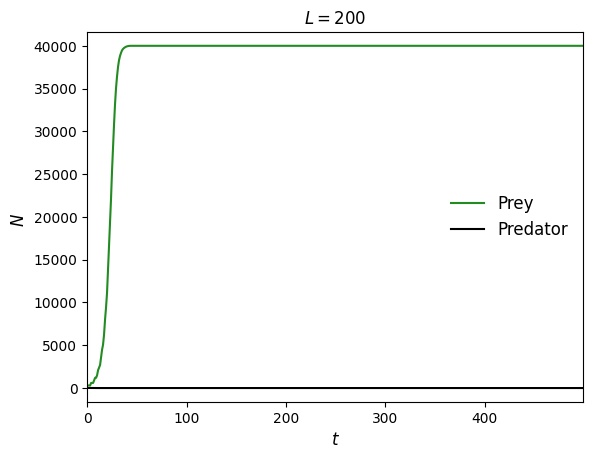

In [32]:
plt.plot(steps, preys,  color='forestgreen', linestyle='solid', label='Prey')
plt.plot(steps, predators,  color='k', linestyle='solid',  label='Predator')

plt.title(fr'$L = 200$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$N$  ', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/Steps200.png', dpi=1200)
plt.show()

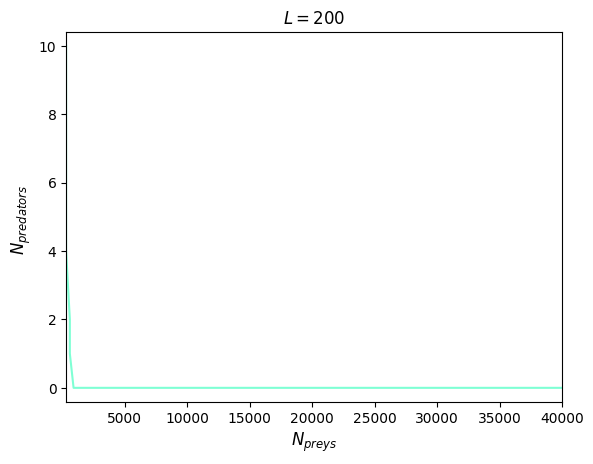

In [33]:
plt.plot(preys, predators,  color='aquamarine', linestyle='solid')

plt.title(fr'$L = 200$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$N_{preys}$', fontsize=12)
plt.ylabel(r'$N_{predators}$  ', fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/PreyPredator200.png', dpi=1200)
plt.show()

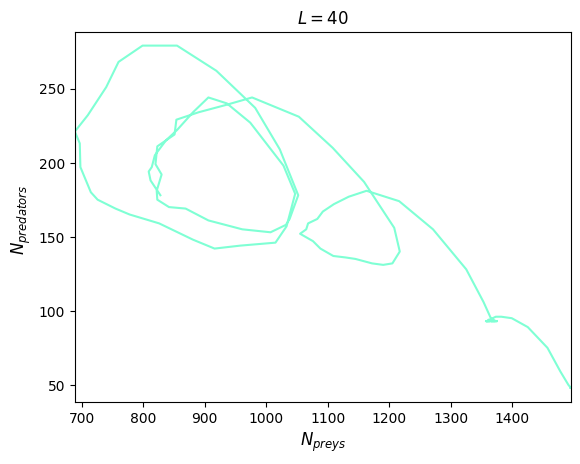

In [ ]:
plt.plot(preys, predators,  color='aquamarine', linestyle='solid')

plt.title(fr'$L = 40$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$N_{preys}$', fontsize=12)
plt.ylabel(r'$N_{predators}$  ', fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/PreyPredator40.png', dpi=1200)
plt.show()

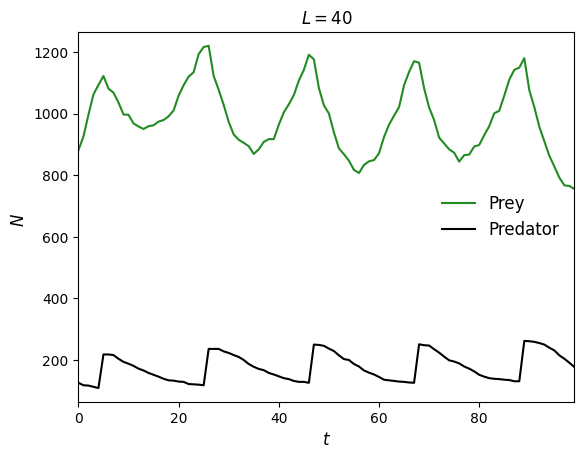

In [ ]:
plt.plot(steps, preys,  color='forestgreen', linestyle='solid', label='Prey')
plt.plot(steps, predators,  color='k', linestyle='solid',  label='Predator')

plt.title(fr'$L = 40$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$t$', fontsize=12)
plt.ylabel(r'$N$  ', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/Steps40.png', dpi=1200)
plt.show()

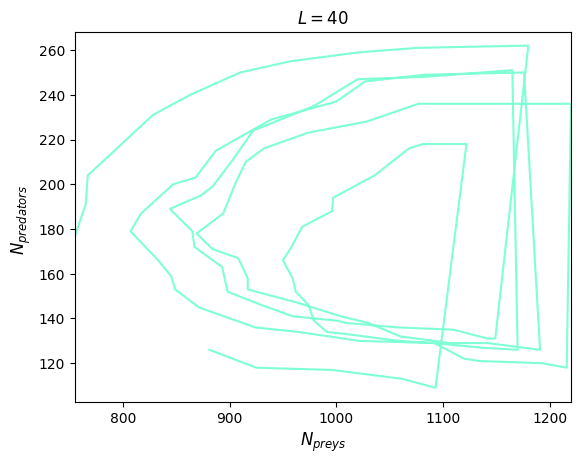

In [ ]:
plt.plot(preys, predators,  color='aquamarine', linestyle='solid')

plt.title(fr'$L = 40$')
plt.margins(x=0.0000005, y=0.04, tight=True)
plt.xlabel(r'$N_{preys}$', fontsize=12)
plt.ylabel(r'$N_{predators}$  ', fontsize=12)
plt.savefig('/content/gdrive/MyDrive/5SEM/SIM/images/WATOR/PreyPredator40.png', dpi=1200)
plt.show()